# Fitting conductances of an action potential model

This tutorial provides a very brief "recipe" to fit maximum conductances (and permeabilities) of action potential (AP) models to a recorded AP trace, using Myokit and PINTS.

## General approach


- [Models are written in Myokit's MMT syntax](https://myokit.readthedocs.io/syntax/index.html), usually by [downloading a CellML model](https://models.cellml.org/electrophysiology) and then [importing it](https://myokit.readthedocs.io/api_formats/cellml.html).
- [Simulations are run](https://myokit.readthedocs.io/api_simulations/Simulation.html) using the `Simulation` class, which uses CVODE to solve the ODEs.
- [A pints.ForwardModel](https://github.com/pints-team/pints/blob/master/examples/optimisation/first-example.ipynb) is wrapped around a Myokit simulation.
- [A pints.ErrorMeasure](https://pints.readthedocs.io/en/latest/error_measures.html) or [pints.LogLikelihood](https://pints.readthedocs.io/en/latest/log_likelihoods.html) is defined
- [Optimisation](https://nbviewer.jupyter.org/github/pints-team/pints/blob/master/examples/optimisation-first-example.ipynb) or [Bayesian inference](https://nbviewer.jupyter.org/github/pints-team/pints/blob/master/examples/sampling-first-example.ipynb) is run.


## Fitting to an action potential

We start by creating an implementation of `pints.ForwardModel` that wraps around a `myokit.Simulation`:

In [2]:
import numpy as np
import pints
import myokit
import matplotlib.pyplot as plt


class APModel(pints.ForwardModel):
    """
    This is a pints model, i.e., a statistical model that takes parameters and
    times as input, and returns simulated values.
    """
    def __init__(self):
        m, p, _ = myokit.load('resources/beeler-1977.mmt')
        self.simulation = myokit.Simulation(m, p)

    def n_parameters(self):
        return 5

    def simulate(self, parameters, times):

        self.simulation.reset()
        self.simulation.set_constant('ina.gNaBar', parameters[0])
        self.simulation.set_constant('ina.gNaC', parameters[1])
        self.simulation.set_constant('isi.gsBar', parameters[2])
        self.simulation.set_constant('ik1.gK1', parameters[3])
        self.simulation.set_constant('ix1.gx1', parameters[4])

        log = self.simulation.run(
            times[-1] + 1,
            log_times = times,
            log = ['membrane.V']
        ).npview()
        return log['membrane.V']

We can use this model to generate some toy data:

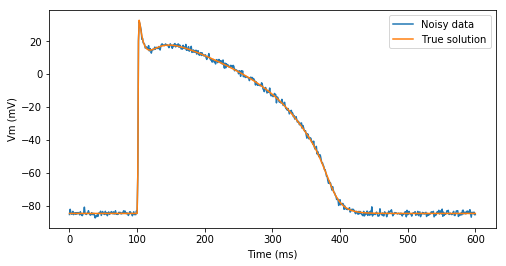

In [3]:
# Create a model
model = APModel()

# Generate some 'experimental' data
x_true = np.array([4, 0.003, 0.09, 0.35, 0.8])
times = np.linspace(0, 600, 601)
values = model.simulate(x_true, times)

# Add noise
noisy_values = np.array(values, copy=True)
noisy_values += np.random.normal(0, 1, values.shape)

plt.figure(figsize=(8, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.plot(times, noisy_values, label='Noisy data')
plt.plot(times, values, label='True solution')
plt.legend()
plt.show()

And finally we can set up an optimisation problem and fit to the data:

In [4]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, noisy_values)

# Create a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
lower = x_true / 5
upper = x_true * 5
boundaries = pints.RectangularBoundaries(lower, upper)

# Perform an optimization
x0 = x_true * 2**np.random.normal(0, 1, x_true.shape)
optimiser = pints.OptimisationController(
    score, x0, boundaries=boundaries, method=pints.CMAES)

print('Running...')
x_found, score_found = optimiser.run()

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(x_found):
    print(pints.strfloat(x) + '    ' + pints.strfloat(x_true[k]))

Running...
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      1888995    0:00.1
1     16     1855883    0:00.2
2     24     1829607    0:00.2
3     32     1804624    0:00.3
20    168    100186     0:01.0
40    328    17277.82   0:01.7
60    488    10404.46   0:02.4
80    648    3918.515   0:03.1
100   808    3173.403   0:03.9
120   968    2084.115   0:04.8
140   1128   1957.409   0:05.6
160   1288   1674.068   0:06.3
180   1448   963.2292   0:07.0
200   1608   790.5655   0:07.8
220   1768   649.9114   0:08.6
240   1928   646.8009   0:09.3
260   2088   646.6613   0:10.0
280   2248   646.6613   0:10.8
300   2408   646.6613   0:11.5
320   2568   646.6527   0:12.3
340   2728   646.6111   0:13.1
360   2888   646.6111   0:13.9
380   3048   646.6111   0:14.8
400   3208   646.6111   0:15.6
420   3368   646.6111   0:16.3
440   3528   646.6111   0:17.0
460   3688   646.

Finally, we inspect the results:

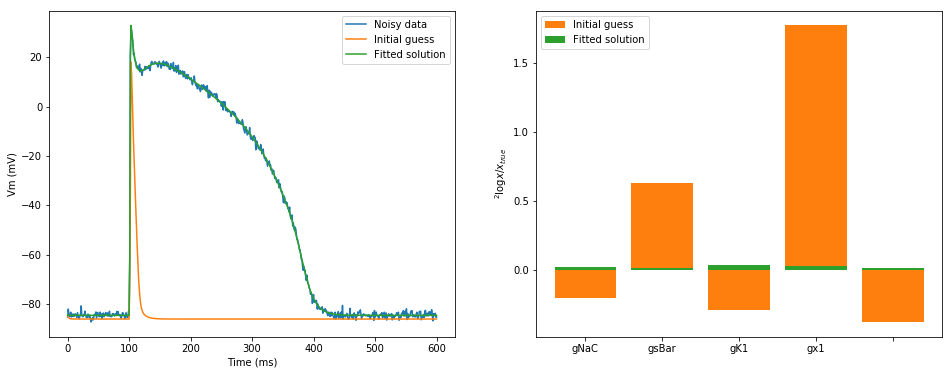

In [5]:
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.plot(times, noisy_values, label='Noisy data')
ax.plot(times, problem.evaluate(x0), label='Initial guess')
ax.plot(times, problem.evaluate(x_found), label='Fitted solution')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
p = ['gNaBar', 'gNaC', 'gsBar', 'gK1', 'gx1']
ax.set_xticklabels(p)
ax.set_ylabel('$^2\log x / x_{true} $')

x = np.arange(1, 1 + len(p))
ax.bar(x, 0 * x)
ax.bar(x, np.log2(x0 / x_true), label='Initial guess')
ax.bar(x, np.log2(x_found / x_true), label='Fitted solution')
ax.legend()
plt.show()

## Summary

In this tutorial, we saw how to wrap a myokit simulation in a PINTS forward model, and use it to set up a synthetic data problem and fit to an AP trace.

In the next tutorial, we'll expand this to also look at the calcium transient.